In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/udacity-mlcharity-competition/census.csv
/kaggle/input/udacity-mlcharity-competition/example_submission.csv
/kaggle/input/udacity-mlcharity-competition/test_census.csv


## 1.1 Import all Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

## 1.2 EDA 

## Description of the problem
CharityML is a fictitious charity organization located in the heart of Silicon Valley that was established to provide financial support for people eager to learn machine learning. After nearly 32,000 letters were sent to people in the community, CharityML determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityML has decided to send letters to residents of California, but to only those most likely to donate to the charity. With nearly 15 million working Californians, CharityML has brought you on board to help build an algorithm to best identify potential donors and reduce overhead cost of sending mail. Your goal will be evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent.

In [3]:
df = pd.read_csv("../input/udacity-mlcharity-competition/census.csv")
df.head(5)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [5]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [6]:
#checking for nan´s 
df.isnull().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [7]:
df.columns

Index(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

### Describe the data 
* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

(array([7308., 8226., 8704., 8811., 5716., 3609., 2000.,  579.,  192.,
          77.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ]),
 <BarContainer object of 10 artists>)

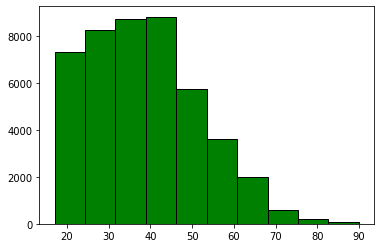

In [8]:
#display age distribution 
plt.hist(df['age'], color = 'green', edgecolor = 'black')

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

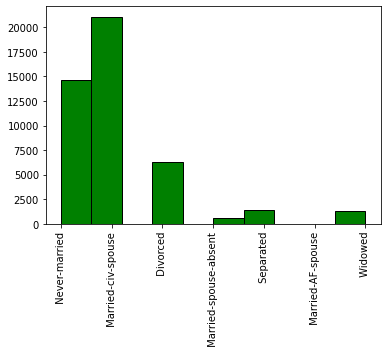

In [9]:
#display maritial status distribution 
plt.hist(df['marital-status'], color = 'green', edgecolor = 'black')
plt.xticks(rotation=90)

 White                 38903
 Black                  4228
 Asian-Pac-Islander     1303
 Amer-Indian-Eskimo      435
 Other                   353
Name: race, dtype: int64

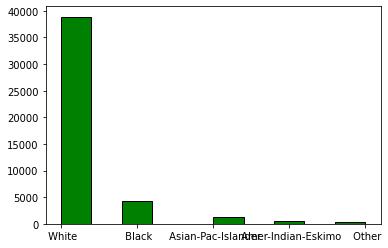

In [10]:
plt.hist(df['race'], color = 'green', edgecolor = 'black')
df['race'].value_counts()

In [11]:
df['sex'].value_counts()

 Male      30527
 Female    14695
Name: sex, dtype: int64

In [12]:
df['income'].value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

income,<=50K,>50K
race,,
Amer-Indian-Eskimo,382,53
Asian-Pac-Islander,934,369
Black,3694,534
Other,308,45
White,28696,10207


<AxesSubplot:xlabel='race'>

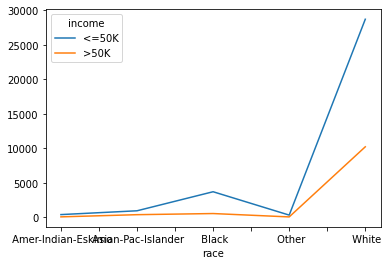

In [13]:
x = df.groupby(['race', 'income']).size().unstack(fill_value = 0)
display(x)
x.plot()

In [14]:
y = df.groupby(['sex', 'income']).size().unstack(fill_value = 0)

display(y)



income,<=50K,>50K
sex,,
Female,13026,1669
Male,20988,9539


In [15]:
df['income_encoded'] = [1 if value == ' >50K' else 0 for value in df['income'].values]
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_encoded
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0


<AxesSubplot:ylabel='occupation'>

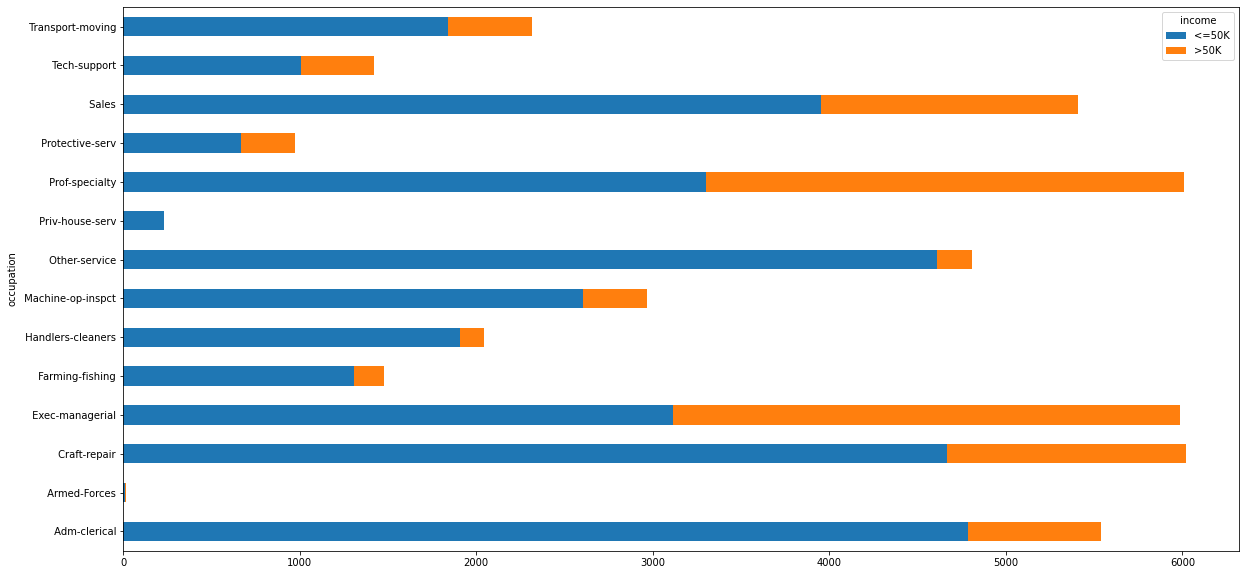

In [16]:
pd.crosstab(df["occupation"], df['income']).plot(kind='barh', stacked=True, figsize=(20, 10))

<AxesSubplot:ylabel='race'>

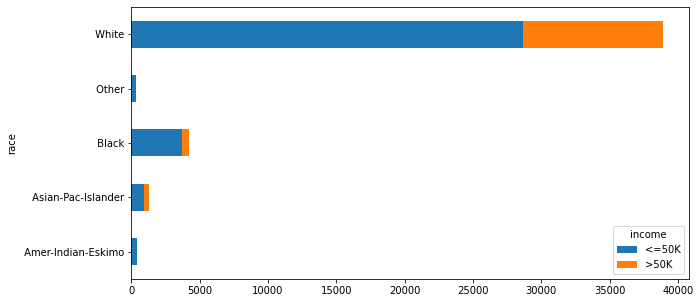

In [17]:
pd.crosstab(df["race"], df['income']).plot(kind='barh', stacked=True, figsize=(10, 5))

<AxesSubplot:ylabel='education-num'>

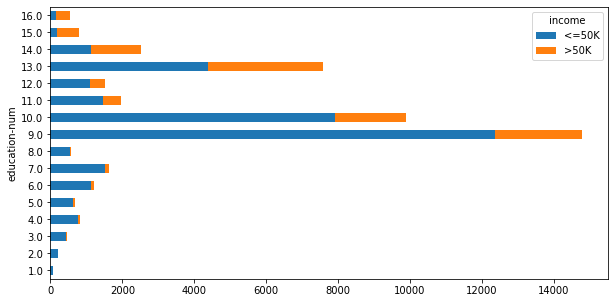

In [18]:
pd.crosstab(df["education-num"], df['income']).plot(kind='barh', stacked=True, figsize=(10, 5))

In [19]:
y = df.groupby(['sex', 'income']).agg({'race': 'count'})
y

race
sex     income       
 Female <=50K   13026
        >50K     1669
 Male   <=50K   20988
        >50K     9539

### Conclusion
the data are very unevenly distributed. Most of the people in the dataset are white and male. </br> 
furthermore the income is also very unevely distributed. </br>
for example the white male people earn more than 50 in 31.24 pct of the cases, but women only 11.35 pct
furthermore you can see that as higher the education is as more likely the person earns more than 50k. 


In [20]:
# TODO: Total number of records
n_records = len(df)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(df[df['income'] == '>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(df[df['income'] == '<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (100/n_records)*n_greater_50k

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


## 2 Normalizing Numerical Features

In [21]:
# Split the data into features and target label
#target label

income_raw = df['income']
print(income_raw.head())

#feature label
features_raw = df.drop('income', axis = 1)
print(features_raw.head())


0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: income, dtype: object
   age          workclass education_level  education-num       marital-status  \
0   39          State-gov       Bachelors           13.0        Never-married   
1   50   Self-emp-not-inc       Bachelors           13.0   Married-civ-spouse   
2   38            Private         HS-grad            9.0             Divorced   
3   53            Private            11th            7.0   Married-civ-spouse   
4   28            Private       Bachelors           13.0   Married-civ-spouse   

           occupation    relationship    race      sex  capital-gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0  

### 2.1 Skewed Data
As to see our data for the capital loss and capital gain is really skewed. But why does this matter? Let´s remember what a normal distribution is: </br>
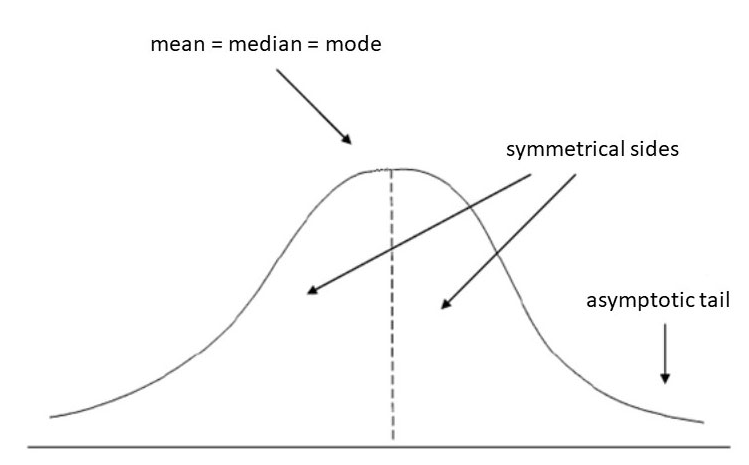 </br>
As our data does not fit to the normal bell curve we may get a problem with our statistical results and with our ML learning model. So we must change this. One method is the logarithm transformation, as this will transform our data to a more normal curve. </br>

https://www.simplypsychology.org/normal-distribution.jpg
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

 skew for capital loss 4.516304152981587


(array([4.3094e+04, 2.3000e+01, 2.8000e+01, 6.3900e+02, 1.1250e+03,
        2.8400e+02, 1.8000e+01, 2.0000e+00, 8.0000e+00, 1.0000e+00]),
 array([   0. ,  435.6,  871.2, 1306.8, 1742.4, 2178. , 2613.6, 3049.2,
        3484.8, 3920.4, 4356. ]),
 <BarContainer object of 10 artists>)

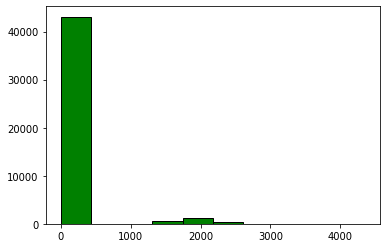

In [22]:
print (f' skew for capital loss {df["capital-loss"].skew()}')
plt.hist(df['capital-loss'], color = 'green', edgecolor = 'black')


 skew for capital gain 11.789002180291192


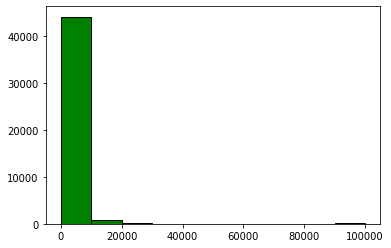

In [23]:
plt.hist(df['capital-gain'], color = 'green', edgecolor = 'black')
print (f' skew for capital gain {df["capital-gain"].skew()}')

In [24]:
# Log-transform the skewed features
#we know that this two columns are highly skewed. 
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))



### 2.2 The Scale of Your Data Matters
Machine learning models learn a mapping from input variables to an output variable.

As such, the scale and distribution of the data drawn from the domain may be different for each variable.

Input variables may have different units (e.g. feet, kilometers, and hours) that, in turn, may mean the variables have different scales.

Differences in the scales across input variables may increase the difficulty of the problem being modeled. An example of this is that large input values (e.g. a spread of hundreds or thousands of units) can result in a model that learns large weight values. A model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error.

Min-max scaling is a common feature pre-processing technique which results in scaled data values that fall in the range [0,1]. When applied to a Python sequence, such as a Pandas Series, scaling results in a new sequence such that 0 is the minimum value and 1 is the maximum value of the prior unscaled sequence. If the sequence is [1, 2, 3], then the scaled sequence is [0, 0.5, 1].


https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/ </br>
https://www.kite.com/python/answers/how-to-scale-pandas-dataframe-columns-with-the-scikit-learn-minmaxscaler-in-python


In [25]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_encoded
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States,0
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States,0
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States,0
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States,0
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba,0


## 3 Data preprocessing
Our machine learning algorithm can not work with categorical features, we need always numerical data. We got two possibilities to arrange that. One is called Label Encoder and the second is called One-Hot-Encoding. The first one gives all our data a number starting from one, two, and so on. But this means we would have some rank in our machine learning algorithm. Because the number one would rank higher than the number two. This can cause a problem. </br>
The second option is that we give all our categorical data a figure between 0 and 1. In the easiest case, we got only two options. For example, we got married and unmarried. Married would get 0 and unmarried would get 0. But if we take divorced also in our data we got already for married 0,0,1 and for unmarried 0,1,0 and for divorced 1,0,0. As you can see this get´s fast a bit confusing. 
In our case we choose One-Hot-encoding. 

In [26]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)


# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

104 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income_encoded', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowe

## 4 Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing. But why?
Normally two problems can occur during our ML training session. Overfitting occurs when the data fits perfect to the model, but when we got new data the algorithm fails. In such a case we got a low bias but a high variance. This can happen because we got not enough data or a lot of noisy data. On the other hand underfitting can also occur. In such a case we got a high bias and also a high variance. Often this happens when the model is not complex enough for our data. 
To find out if the model overfits or underfits we split the data into a training set and a test set. 

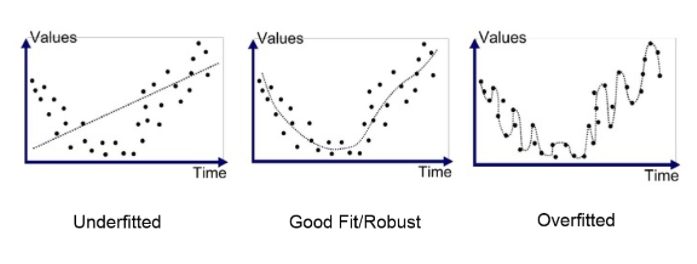

https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76

In [27]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.



##  5 Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Precision and Recall
when we would like to have a high recall value? In the medicine branch if would be very important to have less false negative as possible. Because we don´t want to tell a ill person, that he is healthy. when we would like to have a high precisio value? When we clarify a spam as not spam we can live with that. On the other hand it would be not okay to clarify a very important message as spam. This means we would like to have a low value for false positive. 

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [28]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = accuracy = np.sum(income)/income.count()
recall = 1
precision = accuracy = np.sum(income)/income.count()

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = 1.25 * (accuracy) / ( 0.25 * accuracy + 1)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
